In [2]:
import sys 
sys.path.append('..')

import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

import torch
from utils import *
TensorType = torch.DoubleTensor

from nmgp_dsvi import *

In [3]:
def VTVLCM(data, M, hyperpars=None, initpars={}, batchsize=0, lr=0.005, itnum=2000, do_inference=True,
           do_vi_res_analysis=True, do_plot_post_process=False, do_plot_post_lengthscale_process_log=False,
           seed=22):
    if not os.path.exists("../../res/sim_VI/{}".format(data)):
        os.mkdir("../../res/sim_VI/{}".format(data))

    # Upload Data
    with open("../../data/simulation/" + data +  ".pickle", "rb") as res:
        X_list, Y_list, Xt_list, Yt_list = pickle.load(res)
    z = np.linspace(0, 1, num=M)
    dim_outputs = len(X_list)

    # split training and testing data
    X_train_list = X_list
    X_test_list = Xt_list
    X_train_vec = np.concatenate(X_train_list)
    Y_train_list = Y_list
    Y_test_list = Yt_list
    Y_test_vec = np.concatenate(Y_test_list)
    test_index = np.concatenate([np.ones_like(Y_test_list[i])*i for i in range(dim_outputs)]).astype(int)

    if batchsize == 0:
        batch_size = X_train_vec.shape[0]
    else:
        batch_size = batchsize

    number_grids=200

    if do_inference:
        NMGP_model, _, _ = inference(X_train_list, Y_train_list, z, batch_size, dim_outputs, lr=lr, itnum=itnum,
            hyperpars=hyperpars, fix_hyperpars=True, do_stop_criterion=False, seed=seed,
            verbose=False, show_ELBO=True, **initpars)

        # prediction
        grids = np.linspace(0, 1, number_grids)
        sampled_Ys, sampled_Ls, sampled_Gs, sampled_tilde_ells = sample_Y(NMGP_model, [grids, grids])

        # reconstruction
        sampled_Y_train, _, _, _ = sample_Y(NMGP_model, X_train_list)
        est_Y_train = np.mean(sampled_Y_train, axis=0)
        # est_Y_train = predict_Y(NMGP_model, X_train_list)

        # testing
        sampled_Y_test, _, _, _ = sample_Y(NMGP_model, X_test_list)
        est_Y_test = np.mean(sampled_Y_test, axis=0)
        # est_Y_test = predict_Y(NMGP_model, X_test_list)

        # save results
        with open("../../res/sim_VI/{}/prediction_res_M{}_B{}.pickle".format(data, M, batchsize), "wb") as res:
            pickle.dump([sampled_Ys, sampled_Y_train, est_Y_train, sampled_Y_test, est_Y_test, sampled_tilde_ells], res)
    else:
        grids = torch.from_numpy(np.linspace(0, 1, 200)[:, None]).type(TensorType)
        with open("../../res/sim_VI/{}/prediction_res_M{}_B{}.pickle".format(data,M,batchsize), "rb") as res:
            sampled_Ys, sampled_Y_train, est_Y_train, sampled_Y_test, est_Y_test, sampled_tilde_ells = pickle.load(res)

    if do_vi_res_analysis:
        gridy_mean = np.mean(sampled_Ys, axis=0)
        gridy_quantiles = np.percentile(sampled_Ys, q=(2.5, 97.5), axis =0)
        gridy_Y = np.stack([gridy_quantiles[0, :], gridy_mean, gridy_quantiles[1, :]])
        rmse_train = np.sqrt(np.mean((est_Y_train[:, None] - np.vstack(Y_train_list)) ** 2))
        predy_quantiles = np.percentile(sampled_Y_test, q=(2.5, 97.5), axis=0)
        length_test = np.mean(predy_quantiles[1] - predy_quantiles[0])
        rmse_test = np.sqrt(np.mean((est_Y_test[:, None] - np.vstack(Y_test_list)) ** 2))
        # print("rmse_reconstruction: {}".format(rmse_train))
        # print("rmse_predtiction: {}".format(rmse_test))
        # print("average length of CI: {}".format(length_test))
        # compute coverage rate
        CN = np.zeros(dim_outputs)
        TT = np.zeros(dim_outputs)
        for i in range(Y_test_vec.shape[0]):
            if Y_test_vec[i] > predy_quantiles[0, i] and Y_test_vec[i] < predy_quantiles[1, i]:
                CN[test_index[i]] += 1
            TT[test_index[i]] += 1
        CR = CN/TT
        # print("coverage rate", CR)

    if do_plot_post_process:
        for m in range(dim_outputs):
            fig = plt.figure()
            plt.scatter(X_train_list[m], Y_train_list[m], label="train data")
            plt.plot(grids, gridy_Y[1, m*number_grids:(m+1)*number_grids], color='b')
            plt.plot(grids, gridy_Y[[0, 2], m*number_grids:(m+1)*number_grids].T, color="r", linestyle="dashed")
            plt.xlabel("x", fontsize=25)
            plt.ylabel("y{}".format(m + 1), rotation=0, fontsize=25)
            plt.xticks(fontsize=22)
            plt.yticks(ticks=np.linspace(-6, 12, num=4), fontsize=22)
            plt.ylim(-6, 12)
            plt.scatter(X_test_list[m], Y_test_list[m], color='k', label="test data")
            plt.scatter(X_test_list[m], est_Y_test[:, None][test_index==m], color="r", label='predicted data')
            plt.tight_layout()
            plt.legend(loc="upper right", fontsize=16)
            fig.savefig("../../res/sim_VI/{}/Pos_analysis_{}_{}{}_B{}.png".format(data, m, 'VI', M, batchsize))
            plt.show()

    if do_plot_post_lengthscale_process_log:
        gridlls_mean = np.mean(sampled_tilde_ells, axis=0)
        gridlls_quantiles = np.percentile(sampled_tilde_ells, q=(2.5, 97.5), axis =0)
        fig = plt.figure()
        plt.plot(grids, gridlls_mean[:number_grids], color='b')
        plt.plot(grids, gridlls_quantiles.T[:number_grids], color='r', linestyle="dashed")
        plt.xlabel("x", fontsize=22)
        plt.ylabel("y{}".format(m + 1), rotation=0, fontsize=22)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.tight_layout()
        plt.legend()
        fig.savefig("../../res/sim_VI/{}/Pos_lls_{}_{}{}_B{}.png".format(data, m, 'VI', M, batchsize))
        plt.show()
        return grids, gridlls_mean, gridlls_quantiles

    return rmse_train, rmse_test, length_test, CR

epoch: 100, ELBO: -2981.6837942115358
iteration: 100 batchnum 1 memory use: 311.08984375MB
epoch: 200, ELBO: -1723.7249169398553
iteration: 200 batchnum 1 memory use: 331.08203125MB
epoch: 300, ELBO: -1067.6130359124868
iteration: 300 batchnum 1 memory use: 261.01953125MB
epoch: 400, ELBO: -660.5242877783785
iteration: 400 batchnum 1 memory use: 269.94140625MB
epoch: 500, ELBO: -409.56651680929025
iteration: 500 batchnum 1 memory use: 262.06640625MB
epoch: 600, ELBO: -278.4424943718022
iteration: 600 batchnum 1 memory use: 270.11328125MB
epoch: 700, ELBO: -221.23326715024982
iteration: 700 batchnum 1 memory use: 262.21875MB
epoch: 800, ELBO: -197.69240680421467
iteration: 800 batchnum 1 memory use: 270.09375MB
epoch: 900, ELBO: -184.29667738962112
iteration: 900 batchnum 1 memory use: 269.94921875MB
epoch: 1000, ELBO: -179.0942617214986
iteration: 1000 batchnum 1 memory use: 270.06640625MB
epoch: 1100, ELBO: -168.8057411635937
iteration: 1100 batchnum 1 memory use: 270.1875MB
epoch: 12

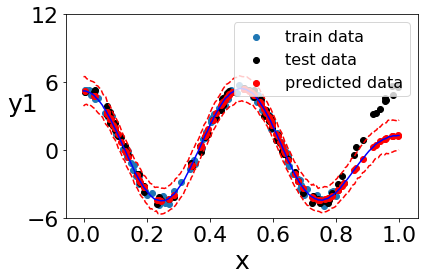

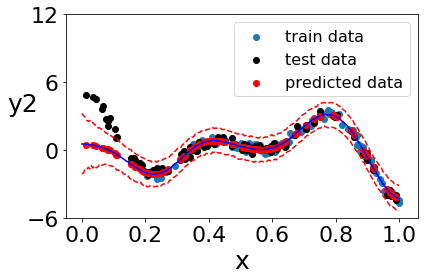

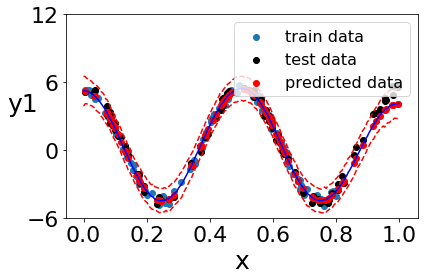

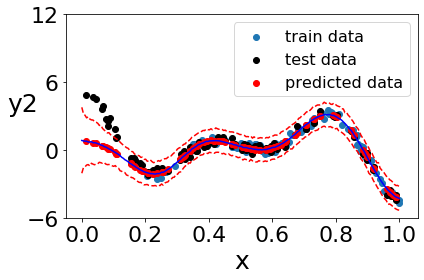

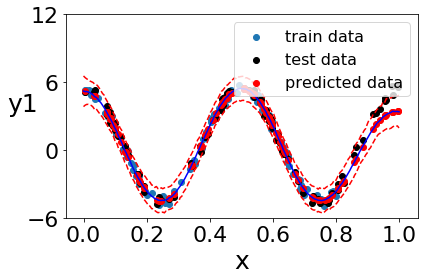

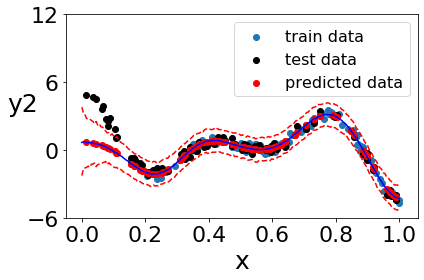

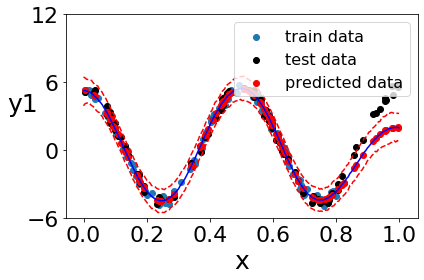

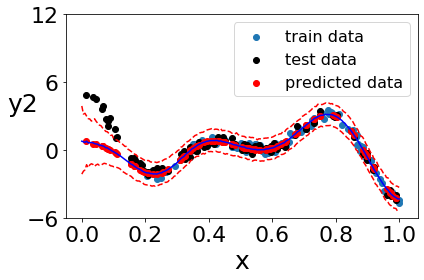

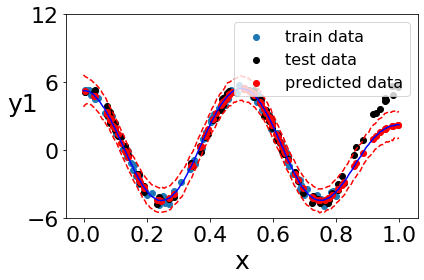

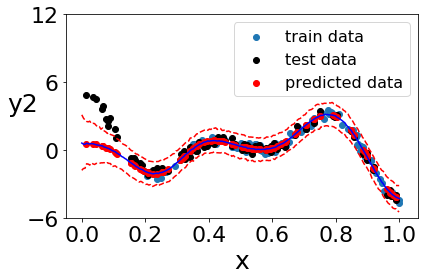

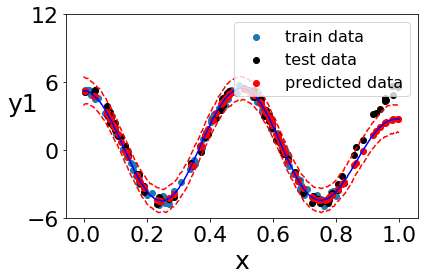

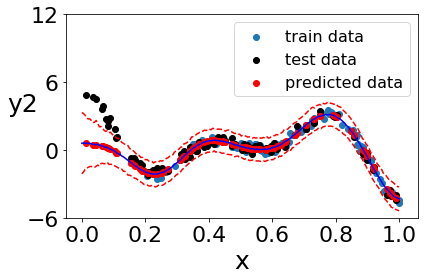

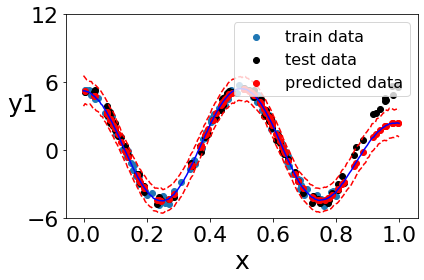

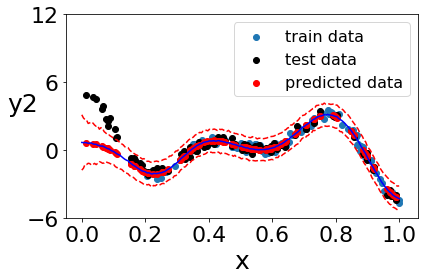

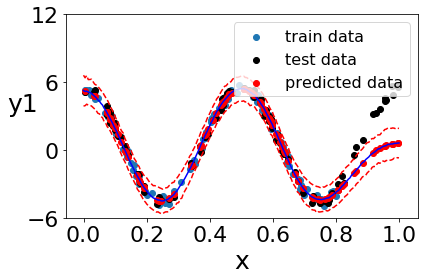

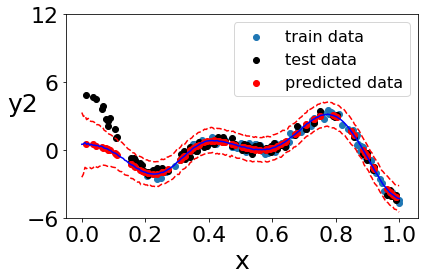

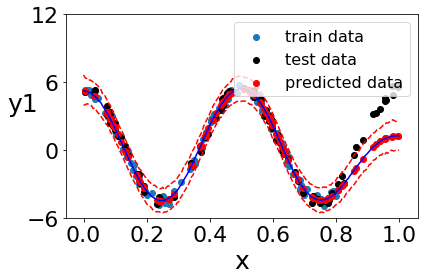

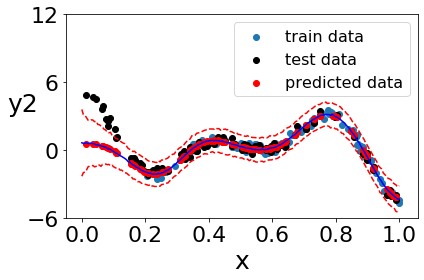

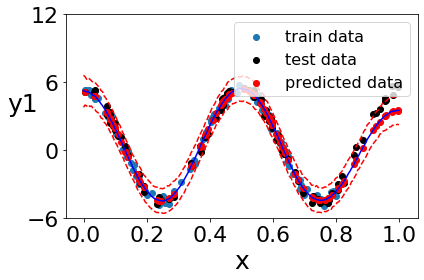

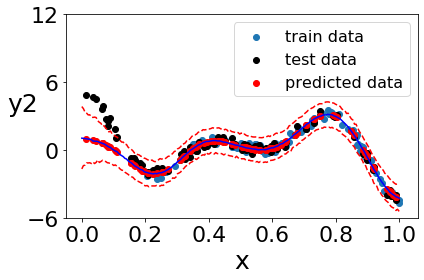

In [15]:
data="sim_illustration_low_freq"
M = 20

# hyperpars = {"length_scales_L0_log": -1, "length_scales_L1_log": -1, "length_scales_tildeell_log": -1, "sigma2_err_log": -2}
hyperpars = {"sigma2_L0_log": 0, "length_scales_L0_log": 2, "sigma2_L1_log": 0, "length_scales_L1_log": 2,
             "sigma2_tildeell_log": 0, "length_scales_tildeell_log": 0, "sigma2_err_log": -2}
# initpars = {"mu_v": -1 * np.ones(M)}
initpars = {}
rmse_test_list = list()
length_test_list = list()
CR_list = list()
for i in range(10):
    rmse_train, rmse_test, length_test, CR = VTVLCM(data, M, do_plot_post_process=True, seed=i, hyperpars=hyperpars, initpars=initpars)
    rmse_test_list.append(rmse_test)
    length_test_list.append(length_test)
    CR_list.append(CR.mean())
rmse_test_array = np.array(rmse_test_list)
length_test_array = np.array(length_test_list)
CR_array = np.array(CR_list)
print("rmse_predtiction:", rmse_test_array.mean(), rmse_test_array.std())
print("average length of CI:", length_test_array.mean(), length_test_array.std())
print("coverage rate:", CR_array.mean(), CR_array.std())
with open("../../res/sim_VI/{}/prediction_measurements.pickle".format(data), "wb") as f:
    pickle.dump([rmse_test_array, length_test_array, CR_array], f)

In [16]:
with open("../../res/sim_VI/{}/prediction_measurements.pickle".format(data), "rb") as f:
    rmse_test_array, length_test_array, CR_array = pickle.load(f)
ind = np.argmin(rmse_test_array)
print(rmse_test_array[ind], length_test_array[ind], CR_array[ind])


0.8175031100782237 2.194048450768173 0.925


epoch: 100, ELBO: -3234.644720817998
iteration: 100 batchnum 1 memory use: 252.01171875MB
epoch: 200, ELBO: -1836.4753204842564
iteration: 200 batchnum 1 memory use: 269.796875MB
epoch: 300, ELBO: -1123.0357242813513
iteration: 300 batchnum 1 memory use: 269.4765625MB
epoch: 400, ELBO: -709.3255591178046
iteration: 400 batchnum 1 memory use: 270.328125MB
epoch: 500, ELBO: -461.9627390957844
iteration: 500 batchnum 1 memory use: 270.54296875MB
epoch: 600, ELBO: -340.66375377731964
iteration: 600 batchnum 1 memory use: 270.5390625MB
epoch: 700, ELBO: -292.6084989162593
iteration: 700 batchnum 1 memory use: 270.5859375MB
epoch: 800, ELBO: -271.25525720424184
iteration: 800 batchnum 1 memory use: 270.609375MB
epoch: 900, ELBO: -261.90607670881667
iteration: 900 batchnum 1 memory use: 270.57421875MB
epoch: 1000, ELBO: -256.32197071613507
iteration: 1000 batchnum 1 memory use: 270.3203125MB
epoch: 1100, ELBO: -251.07773335115587
iteration: 1100 batchnum 1 memory use: 270.5703125MB
epoch: 120

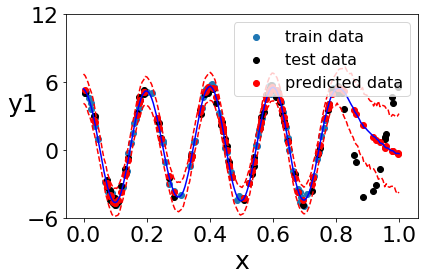

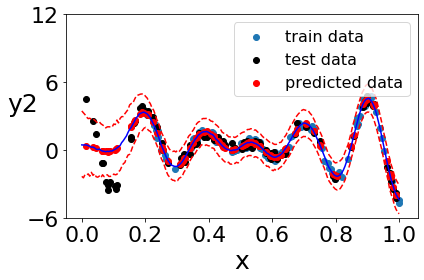

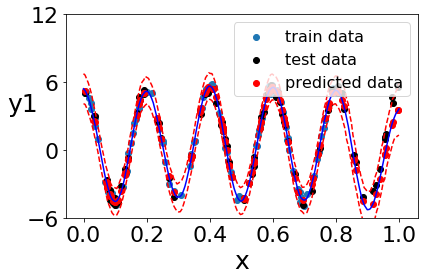

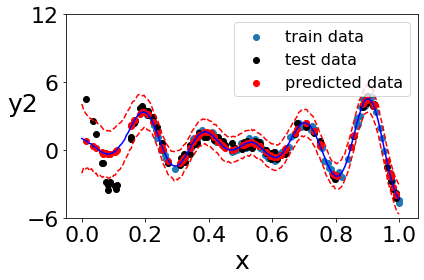

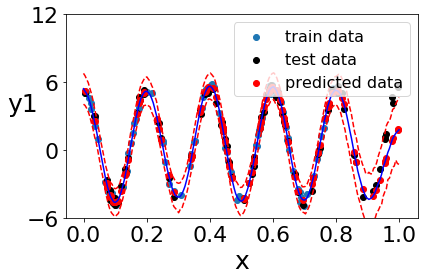

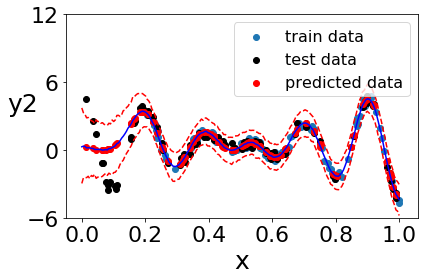

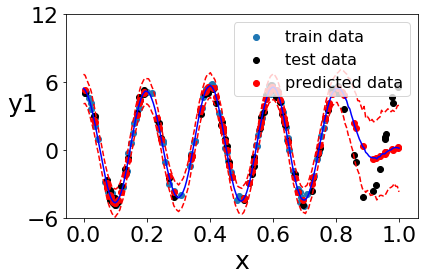

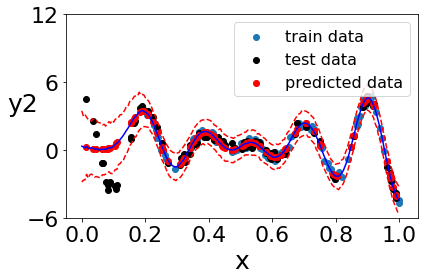

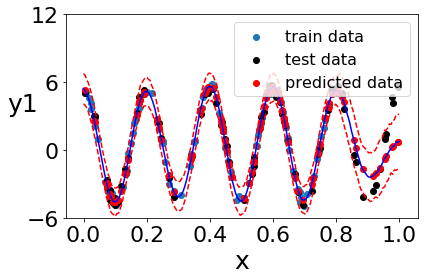

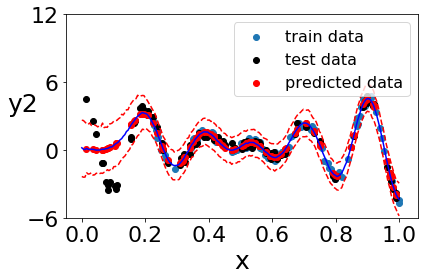

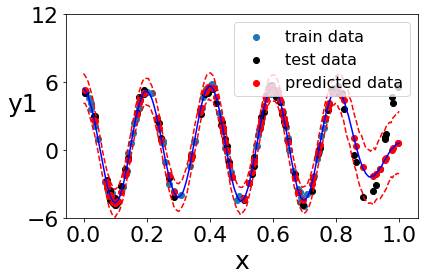

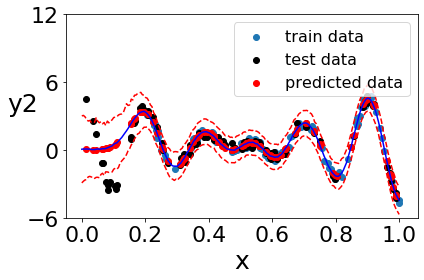

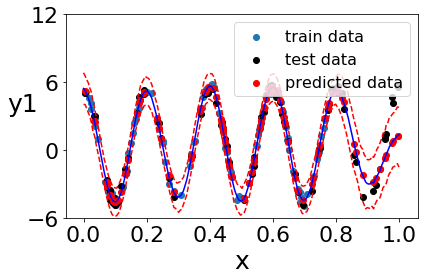

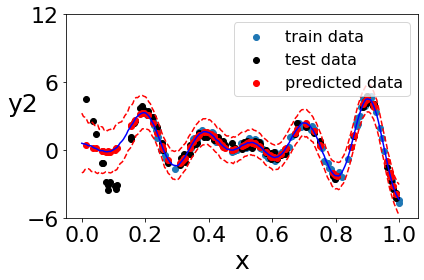

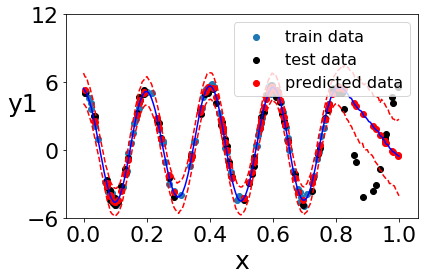

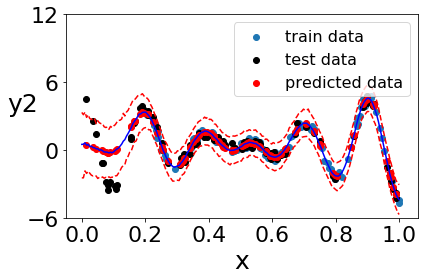

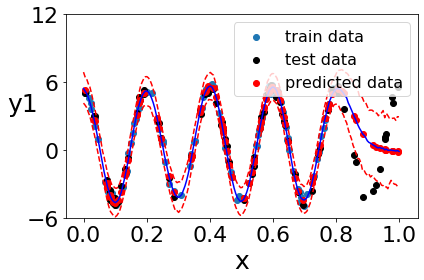

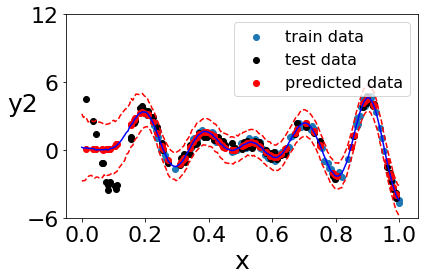

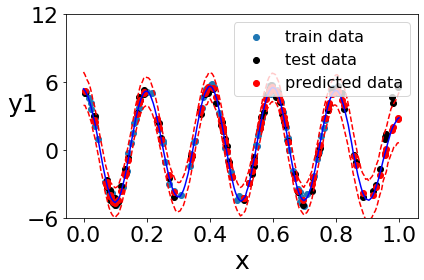

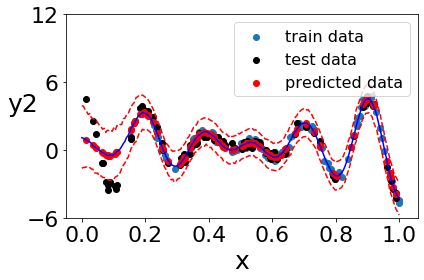

In [17]:
data="sim_illustration_high_freq"
M = 20
hyperpars = {"sigma2_L0_log": 0, "length_scales_L0_log": 2, "sigma2_L1_log": 0, "length_scales_L1_log": 2,
             "sigma2_tildeell_log": 0, "length_scales_tildeell_log": 0, "sigma2_err_log": -2}# initpars = {"mu_v": -1 * np.ones(M)}
initpars = {}

rmse_test_list = list()
length_test_list = list()
CR_list = list()
for i in range(10):
    rmse_train, rmse_test, length_test, CR = VTVLCM(data, M, do_plot_post_process=True, seed=i, hyperpars=hyperpars, initpars=initpars)
    rmse_test_list.append(rmse_test)
    length_test_list.append(length_test)
    CR_list.append(CR.mean())
rmse_test_array = np.array(rmse_test_list)
length_test_array = np.array(length_test_list)
CR_array = np.array(CR_list)
print("rmse_predtiction:", rmse_test_array.mean(), rmse_test_array.std())
print("average length of CI:", length_test_array.mean(), length_test_array.std())
print("coverage rate:", CR_array.mean(), CR_array.std())
with open("../../res/sim_VI/{}/prediction_measurements.pickle".format(data), "wb") as f:
    pickle.dump([rmse_test_array, length_test_array, CR_array], f)

In [18]:
with open("../../res/sim_VI/{}/prediction_measurements.pickle".format(data), "rb") as f:
    rmse_test_array, length_test_array, CR_array = pickle.load(f)
ind = np.argmin(rmse_test_array)
print(rmse_test_array[ind], length_test_array[ind], CR_array[ind])


0.7974654481325996 2.6020305795714216 0.95


epoch: 100, ELBO: -3591.510870851272
iteration: 100 batchnum 1 memory use: 255.2734375MB
epoch: 200, ELBO: -2085.6878150542157
iteration: 200 batchnum 1 memory use: 266.1484375MB
epoch: 300, ELBO: -1287.7930120394067
iteration: 300 batchnum 1 memory use: 263.76953125MB
epoch: 400, ELBO: -802.5899393226401
iteration: 400 batchnum 1 memory use: 266.63671875MB
epoch: 500, ELBO: -493.08812559255654
iteration: 500 batchnum 1 memory use: 266.828125MB
epoch: 600, ELBO: -345.5604294654236
iteration: 600 batchnum 1 memory use: 266.66796875MB
epoch: 700, ELBO: -289.76502591974463
iteration: 700 batchnum 1 memory use: 266.83984375MB
epoch: 800, ELBO: -267.69671313218583
iteration: 800 batchnum 1 memory use: 275.15625MB
epoch: 900, ELBO: -256.63701216796085
iteration: 900 batchnum 1 memory use: 275.01953125MB
epoch: 1000, ELBO: -251.0626350543647
iteration: 1000 batchnum 1 memory use: 275.18359375MB
epoch: 1100, ELBO: -247.01814414966958
iteration: 1100 batchnum 1 memory use: 275.11328125MB
epoch:

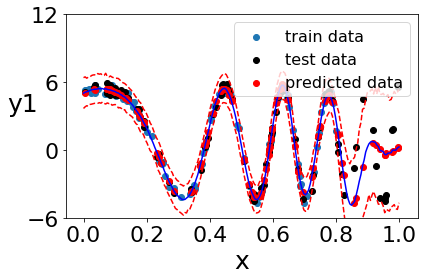

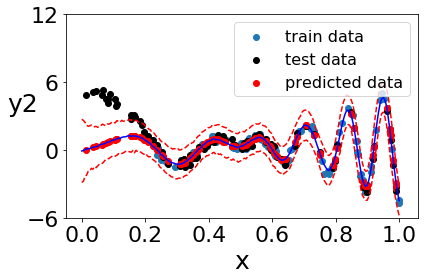

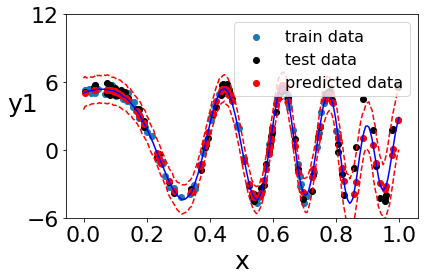

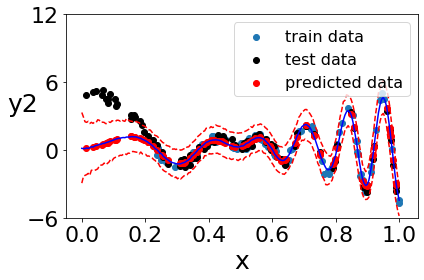

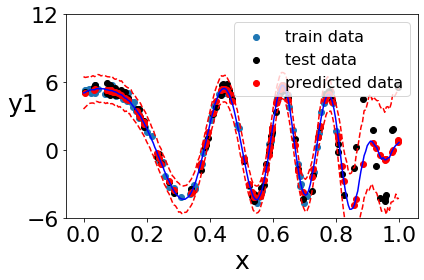

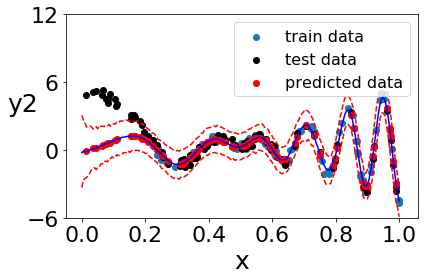

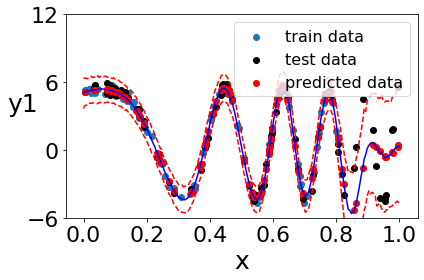

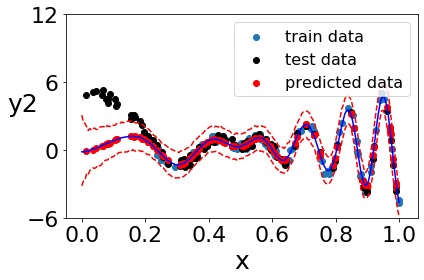

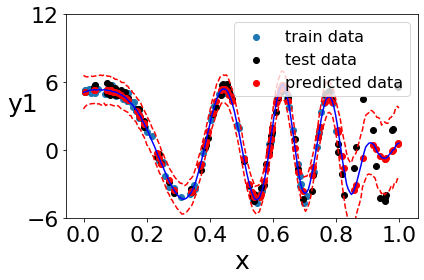

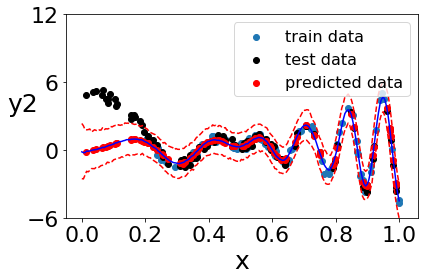

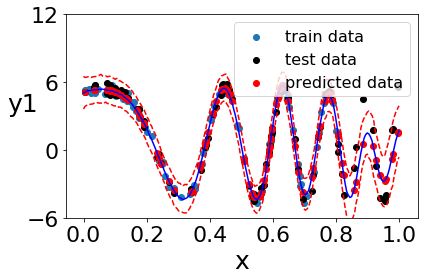

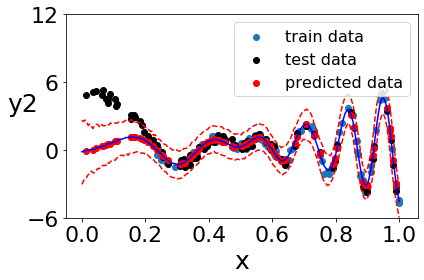

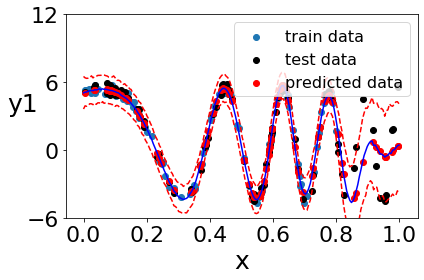

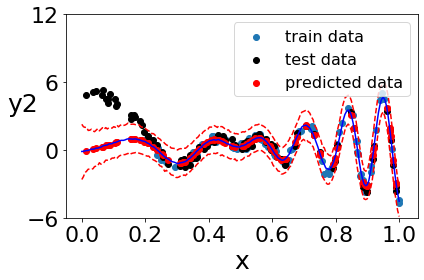

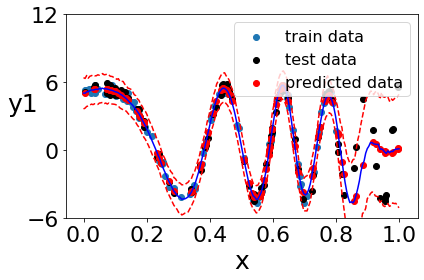

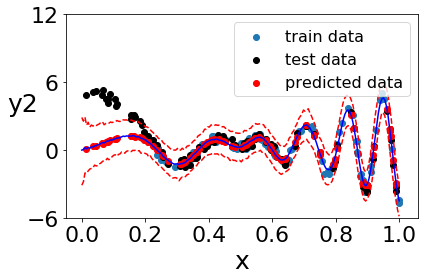

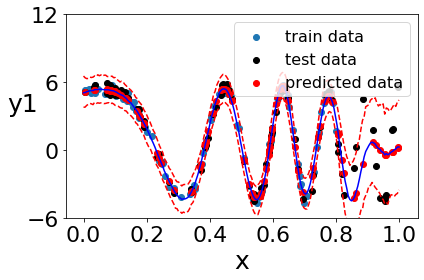

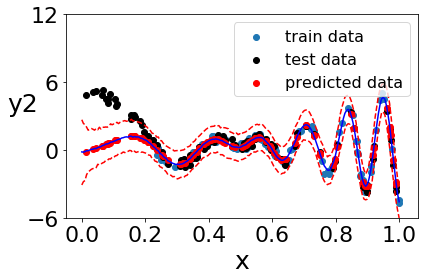

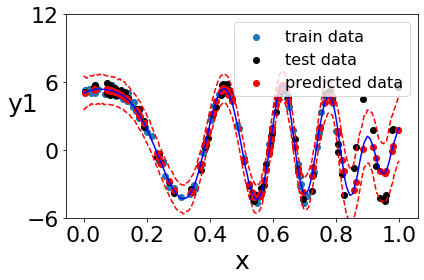

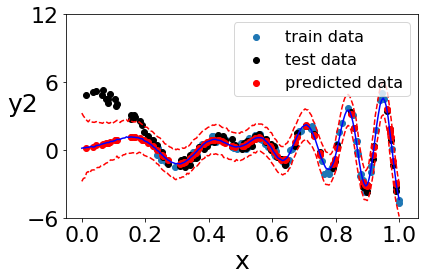

In [4]:
data="sim_illustration_varying_freq"
M = 20
hyperpars = {"sigma2_L0_log": 0, "length_scales_L0_log": 2, "sigma2_L1_log": 0, "length_scales_L1_log": 2,
             "sigma2_tildeell_log": 0, "length_scales_tildeell_log": 0, "sigma2_err_log": -2}# initpars = {"mu_v": -1 * np.ones(M)}
initpars = {}

rmse_test_list = list()
length_test_list = list()
CR_list = list()
for i in range(10):
    rmse_train, rmse_test, length_test, CR = VTVLCM(data, M, do_plot_post_process=True, seed=i, hyperpars=hyperpars, initpars=initpars)
    rmse_test_list.append(rmse_test)
    length_test_list.append(length_test)
    CR_list.append(CR.mean())
rmse_test_array = np.array(rmse_test_list)
length_test_array = np.array(length_test_list)
CR_array = np.array(CR_list)
print("rmse_predtiction:", rmse_test_array.mean(), rmse_test_array.std())
print("average length of CI:", length_test_array.mean(), length_test_array.std())
print("coverage rate:", CR_array.mean(), CR_array.std())
with open("../../res/sim_VI/{}/prediction_measurements.pickle".format(data), "wb") as f:
    pickle.dump([rmse_test_array, length_test_array, CR_array], f)

In [5]:
data="sim_illustration_varying_freq"
with open("../../res/sim_VI/{}/prediction_measurements.pickle".format(data), "rb") as f:
    rmse_test_array, length_test_array, CR_array = pickle.load(f)
ind = np.argmin(rmse_test_array)
print(rmse_test_array[ind], length_test_array[ind], CR_array[ind])

1.2235598665930727 2.7914191866392217 0.8899999999999999


In [ ]:
data="sim_illustration_low_freq"
M = 20
hyperpars = {"sigma2_L0_log": 0, "length_scales_L0_log": 2, "sigma2_L1_log": 0, "length_scales_L1_log": 2,
             "sigma2_tildeell_log": 0, "length_scales_tildeell_log": 0, "sigma2_err_log": -2}
# initpars = {"mu_v": -1 * np.ones(M)}
initpars = {}

grids, gridlls_mean_low, gridlls_quantiles_low = VTVLCM(data, M, lr=0.005, do_inference=False, do_plot_post_process=True,
            do_plot_post_lengthscale_process_log=True, seed=9, hyperpars=hyperpars, initpars=initpars)

In [ ]:
data="sim_illustration_high_freq"
M = 20
hyperpars = {"sigma2_L0_log": 0, "length_scales_L0_log": 2, "sigma2_L1_log": 0, "length_scales_L1_log": 2,
             "sigma2_tildeell_log": 0, "length_scales_tildeell_log": 0, "sigma2_err_log": -2}
# initpars = {"mu_v": -1 * np.ones(M)}
initpars = {}

grids, gridlls_mean_high, gridlls_quantiles_high = VTVLCM(data, M, lr=0.005, do_inference=False, do_plot_post_process=True,
            do_plot_post_lengthscale_process_log=True, seed=9, hyperpars=hyperpars, initpars=initpars)

In [ ]:
data="sim_illustration_varying_freq"
M = 20
hyperpars = {"sigma2_L0_log": 0, "length_scales_L0_log": 2, "sigma2_L1_log": 0, "length_scales_L1_log": 2,
             "sigma2_tildeell_log": 0, "length_scales_tildeell_log": 0, "sigma2_err_log": -2}
# initpars = {"mu_v": -1 * np.ones(M)}
initpars = {}

grids, gridlls_mean_varying, gridlls_quantiles_varying = VTVLCM(data, M, lr=0.005, do_inference=False, do_plot_post_process=True,
            do_plot_post_lengthscale_process_log=True, seed=9, hyperpars=hyperpars, initpars=initpars)

In [ ]:
data="sim_illustration"
number_grids=200
m=20
fig = plt.figure()
plt.plot(grids, gridlls_mean_low[:number_grids], color='b', label="LF")
# plt.plot(grids, gridlls_quantiles_low.T[:number_grids], color='r', linestyle="dashed")
plt.plot(grids, gridlls_mean_high[:number_grids], color='y', label="HF")
# plt.plot(grids, gridlls_quantiles_high.T[:number_grids], color='r', linestyle="dashed")
plt.plot(grids, gridlls_mean_varying[:number_grids], color='g', label="VF")
# plt.plot(grids, gridlls_quantiles_varying.T[:number_grids], color='r', linestyle="dashed")
plt.xlabel("x", fontsize=22)
plt.ylabel("", fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim(-4,-1.5)
plt.legend(loc="upper right", fontsize=16)
plt.tight_layout()
fig.savefig("../../res/sim_VI/{}/Pos_lls.png".format(data))
plt.show()